____________________________________

<div align="center">
  
# Reinforcement learning :
# How to solve the Frozen Lake problem with Q-Learning  <div align="center"> 
_____________________________________

In [20]:
import gym
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make('FrozenLake8x8-v0').env

In [3]:
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [4]:
env.P[9] 

{0: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 17, 0.0, False)],
 1: [(0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 17, 0.0, False),
  (0.3333333333333333, 10, 0.0, False)],
 2: [(0.3333333333333333, 17, 0.0, False),
  (0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 3: [(0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 8, 0.0, False)]}

The dictionnary env.P has the following structure: {action : list of states reachable with this action at this state (probability, next state, reward, done)

In [6]:
env.s #the agent is at the initial position

0

### Random strategy:
First let's try a random strategy and see how it performs:

In [101]:
env.s=0
nb_parties=1000
reward_total = 0
frames = []
for i in range(nb_parties):
    env.s=0
    a=(0, 0.0, False, {'prob': 0.3333333333333333})
    while not a[2]:
        action= env.action_space.sample()
        a=env.step(action)
        reward_total+=a[1]
            # Put each rendered frame into dict for animation
        frames.append({'frame': env.render(mode='ansi'),'state': a[0],'action': action,'reward': a[1]})
        
print('For a total of ',nb_parties,' games played, the agent moving randomly played ',len(frames),
      ' moves. \nAn average of ',len(frames)/nb_parties,
      ' moves per game.\nAnd an average reward per game of :',reward_total/nb_parties)


For a total of  1000  games played, the agent moving randomly played  31428  moves. 
An average of  31.428  moves per game.
And an average reward per game of : 0.001


In [16]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        env.s=frames[i]['state']
        env.render()
        print("Timestep: ",{i + 1})
        print("State: ",{frame['state']})
        print("Action: ",{frame['action']})
        print("Reward: ",{frame['reward']})
        sleep(.1)
        
print_frames(frames)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Timestep:  {31}
State:  {19}
Action:  {1}
Reward:  {0.0}


As we might expected, a random strategy is not really efficient. The agent ends in a hole most of the games. 
<br> __Let's start learning!__ 

### Q-learning

In [17]:
#creation of the Q-table
Q_table=pd.DataFrame([[0]*env.action_space.n]*env.observation_space.n)
Q_table=Q_table.rename_axis('state')

In [9]:
def sum_segments(liste,len_segment):
    L=[]
    for i in range(len(liste)//len_segment):
        L.append(sum(liste[len_segment*i:len_segment*(i+1)]))
    return L

In [237]:
# Hyperparameters: on augmente gamma (discount factor) et alpha (learning rate, because the learning seems too slow)
alpha = 0.8
gamma = 0.9
#epsilon = 0.1 #10% of exploration

#frames = []

Q_table2=pd.DataFrame([[0]*env.action_space.n]*env.observation_space.n)
Q_table2.rename_axis('state')

nb_parties=30000
#reward_game2=[]
for i in range(nb_parties):
    env.s=0
    state=0
    reward = 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:    #exploration
            action = env.action_space.sample() 
        else:   #exploitation
            qmax = Q_table2.iloc[state,np.argmax(Q_table2.iloc[state])] #the maximum value in the Q_table at state state
            action = random.choice(np.where(Q_table2.iloc[state]==qmax)[0])     #pick up randomly an action in the list of equal maximum Q-value actions 
                                                                        #or the max Q-value if there's only one. (othewhise the agent keep taking the first appearing action while there is several max q-value actions)
           
        a = env.step(action) 
        
        q_s_a = Q_table2.iloc[state, action]
        next_max = np.max(Q_table2.iloc[env.s])
        
        new_q_s_a = (1 - alpha) * q_s_a + alpha * (a[1] + gamma * next_max)
        Q_table2.iloc[state, action] = new_q_s_a
        reward+=a[1]
        if reward:
            print('win')
        state = env.s
        
        done=a[2]
        
        # Put each rendered frame into dict for animation
        frames.append({'game':i, 'frame': env.render(mode='ansi'),'state': a[0],'action': action,'reward': a[1]})
  
        
    reward_game2.append(reward)    
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")


Episode: 29900
win
win
win
win
win
win
win
win
win
win


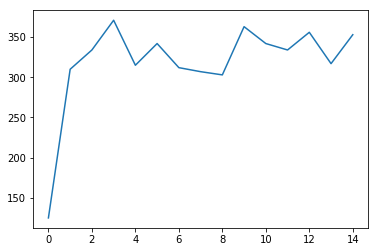

In [236]:
import matplotlib.pyplot as plt
plt.plot(range(int(len(reward_game2)/2000)),sum_segments(reward_game2,2000))

We can notice that the success stagnate around 17%.

In [164]:
print_frames(frames)

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Timestep: 1285
State: 32
Action: 0
Reward: 0.0


KeyboardInterrupt: 

### Modification of the hyper parameters and progressive decrease of $\epsilon$ during the training:

In [25]:
# Hyperparameters: We increase gamma (discount factor) et alpha (learning rate, because the learning seems too slow)
alpha = 0.8
gamma = 0.9

#frames = []

#Q_table2=pd.DataFrame([[0]*env.action_space.n]*env.observation_space.n)


nb_parties=140000
#reward_game2=[]
for i in range(nb_parties):
    #epsilon = 0.02 + 0.05*(nb_parties-i)/nb_parties #7% of exploration at the begining and 2% at the end 
    epsilon = 0.01 
    env.s=0
    state=0
    reward = 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:    #exploration
            action = env.action_space.sample() 
        else:   #exploitation
            qmax = Q_table2.iloc[state,np.argmax(Q_table2.iloc[state])] #the maximum value in the Q_table at state state
            action = random.choice(np.where(Q_table2.iloc[state]==qmax)[0])     #pick up randomly an action in the list of equal maximum Q-value actions 
                                                                        #or the max Q-value if there's only one. (othewhise the agent keep taking the first appearing action while there is several max q-value actions)
           
        a = env.step(action) 
        
        q_s_a = Q_table2.iloc[state, action]
        next_max = np.max(Q_table2.iloc[env.s])
        
        new_q_s_a = (1 - alpha) * q_s_a + alpha * (a[1] + gamma * next_max)
        Q_table2.iloc[state, action] = new_q_s_a
        reward+=a[1]
        if reward:
            print('win')
        state = env.s
        
        done=a[2]
        
        # Put each rendered frame into dict for animation
        frames.append({'game':i, 'frame': env.render(mode='ansi'),'state': a[0],'action': action,'reward': a[1]})
  
        
    reward_game2.append(reward)    
        
    if i % 100 == 0:
        clear_output(wait=True)
        print("Episode: ",i+100000)
    if i % 1000 ==0:
        clear_output(wait=True)
        print('total reward on the 1000 last epochs:', sum(reward_game2[-1000:-1]))


Episode:  149900
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win
win


In [240]:
print('total reward on the 1000 last epochs:', sum(reward_game2[-1000:-1]))

total reward on the 1000 last epochs: 169.0


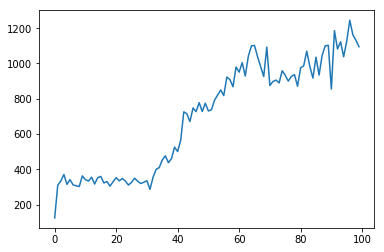

In [264]:
plt.plot(range(int(len(reward_game2)/2000)),sum_segments(reward_game2,2000))

### Learning from scratch with the chosen parameters and a decreasing $\epsilon$

In [ ]:
alpha = 0.8
gamma = 0.9

frames = []

Q_table2=pd.DataFrame([[0]*env.action_space.n]*env.observation_space.n)


nb_parties=50000
reward_game2=[]
for i in range(nb_parties):
    epsilon = 0.01 + 0.06*(nb_parties-i)/nb_parties #7% of exploration at the begining and 2% at the end 
    env.s=0
    state=0
    reward = 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:    #exploration
            action = env.action_space.sample() 
        else:   #exploitation
            qmax = Q_table2.iloc[state,np.argmax(Q_table2.iloc[state])] #the maximum value in the Q_table at state state
            action = random.choice(np.where(Q_table2.iloc[state]==qmax)[0])     #pick up randomly an action in the list of equal maximum Q-value actions 
                                                                        #or the max Q-value if there's only one. (othewhise the agent keep taking the first appearing action while there is several max q-value actions)
           
        a = env.step(action) 
        
        q_s_a = Q_table2.iloc[state, action]
        next_max = np.max(Q_table2.iloc[env.s])
        
        new_q_s_a = (1 - alpha) * q_s_a + alpha * (a[1] + gamma * next_max)
        Q_table2.iloc[state, action] = new_q_s_a
        reward+=a[1]
        if reward:
            print('win')
        state = env.s
        
        done=a[2]
        
        # Put each rendered frame into dict for animation
        frames.append({'game':i, 'frame': env.render(mode='ansi'),'state': a[0],'action': action,'reward': a[1]})
  
        
    reward_game2.append(reward)    
        
    if i % 100 == 0:
        clear_output(wait=True)
        print("Episode: ",i+100000)
    if i % 1000 ==0:
        clear_output(wait=True)
        print('total reward on the 1000 last epochs:', sum(reward_game2[-1000:-1]))


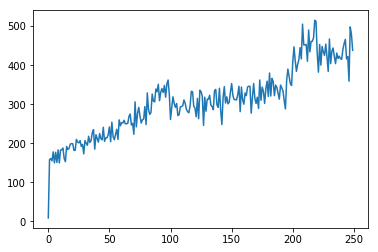

In [26]:
plt.plot(range(int(len(reward_game2)/1000)),sum_segments(reward_game2,1000))

### Test of the policy : $\hat{\Pi}^*$

In [30]:
nb_parties=200
reward_game_test=[]
for i in range(nb_parties):
    env.s=0
    state=0
    reward = 0
    done = False
    
    while not done:
    # only exploitation
        action = np.argmax(Q_table2.iloc[state])     
                                                                    
        a = env.step(action) 
        reward+=a[1]
        if reward:
            print('win')
        state = env.s
        
        done=a[2]
        
        # Put each rendered frame into dict for animation
        frames.append({'game':i, 'frame': env.render(mode='ansi'),'state': a[0],'action': action,'reward': a[1]})
  
        
    reward_game_test.append(reward)    
        
    if i % 100 == 0:
        clear_output(wait=True)
        print("Episode: ",i)

Episode:  100
win
win
win
win
win
win
win
win
win
win
win
